In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import math
from dataclasses import dataclass
from functools import partial
from typing import Callable, Optional, Tuple, Union

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import scipy.stats
import seaborn as sns
from tqdm.notebook import tqdm

import score_analysis
from score_analysis import BinaryLabel, BootstrapConfig, Scores
from score_analysis.experimental.roc_ci import (
    NormalDataset, 
    fixed_width_band_ci,
    pointwise_band_ci,
    roc, 
    roc_with_ci,
    simultaneous_joint_region_ci,
)

In [3]:
sns.set_style("darkgrid")
sns.set_context("notebook")

In [4]:
dataset = NormalDataset(
    mu_pos=0.8,
    mu_neg=np.sqrt(2),
    sigma_pos=0.1,
    sigma_neg=0.1,
    score_class="neg",
)
scores = dataset.sample(n=1_000_000, p_pos=0.01)

fnr, fpr = roc(scores, fpr=np.logspace(-6, -1, 1_000, endpoint=True))

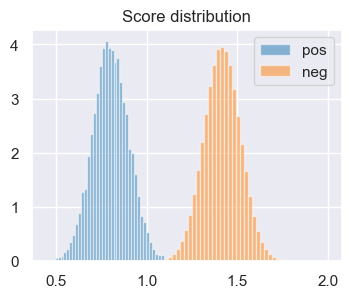

In [15]:
plt.figure(figsize=(4, 3))
plt.hist(scores.pos, bins=50, alpha=0.5, density=True, label="pos")
plt.hist(scores.neg, bins=50, alpha=0.5, density=True, label="neg")
plt.legend()
plt.title("Score distribution")
plt.show()

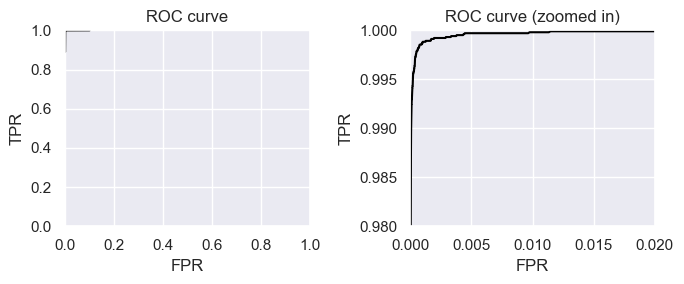

In [5]:
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
plt.plot(fpr, 1. - fnr, "k-")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")

plt.subplot(1, 2, 2)
plt.plot(fpr, 1. - fnr, "k-")
plt.xlim([0, 0.02])
plt.ylim([0.98, 1.0])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve (zoomed in)")

plt.tight_layout()
plt.show()

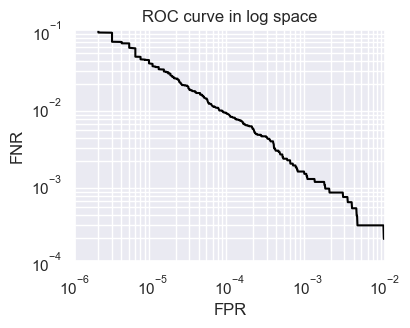

In [6]:
plt.figure(figsize=(4, 3))
plt.plot(fpr, fnr, "k-")
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1e-2])
plt.ylim([1e-4, 1e-1])
plt.grid(which="both")
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("ROC curve in log space")
plt.show()

In [7]:
fnr, fpr, fnr_ci, fpr_ci = roc_with_ci(
    scores=scores,
    fpr=np.logspace(-6, -2, 100),
    alpha=0.05,
)

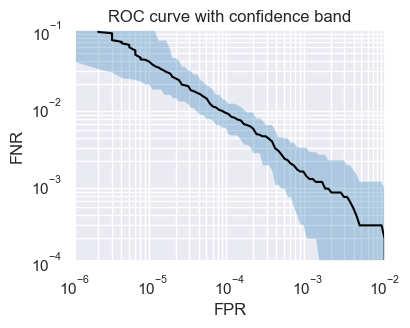

In [11]:
plt.figure(figsize=(4, 3))
plt.plot(fpr, fnr, "k-")
plt.fill_between(fpr, fnr_ci[:, 0], fnr_ci[:, 1], alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1e-2])
plt.ylim([1e-4, 1e-1])
plt.grid(which="both")
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("ROC curve with confidence band")
plt.show()

In [12]:
scores_small = dataset.sample(n=400_000, p_pos=0.01)
fnr_small, fpr_small, fnr_ci_small, fpr_ci_small = roc_with_ci(
    scores=scores_small,
    fpr=np.logspace(-6, -2, 100),
    alpha=0.05,
)

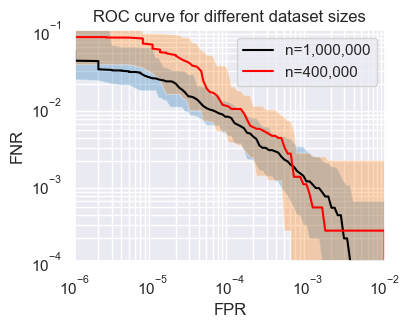

In [16]:
plt.figure(figsize=(4, 3))
plt.plot(fpr, fnr, "k-", label="n=1,000,000")
plt.fill_between(fpr, fnr_ci[:, 0], fnr_ci[:, 1], alpha=0.3)

plt.plot(fpr_small, fnr_small, "r-", label="n=400,000")
plt.fill_between(fpr_small, fnr_ci_small[:, 0], fnr_ci_small[:, 1], alpha=0.3)

plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1e-2])
plt.ylim([1e-4, 1e-1])
plt.grid(which="both")
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("ROC curve for different dataset sizes")
plt.legend()
plt.show()

## CIs and dataset size

In [18]:
dataset = NormalDataset.from_metrics(
    fnr=0.001,
    fpr=0.001,
    fnr_support=100,
    fpr_support=100,
)

fnr = 1e-3

In [19]:
fpr_list = np.array([0.01, 0.03, 0.1])
support_list = [3, 10, 30, 100, 300]
alpha = 0.05

ci = np.empty((len(fpr_list), len(support_list), 2))
for j, fpr in enumerate(fpr_list):
    for k, support in enumerate(support_list):
        n = math.ceil(support / fpr)
        neg = np.random.normal(loc=0.0, scale=1.0, size=n)
        scores = Scores(pos=[], neg=neg)
        
        threshold = scores.threshold_at_fpr(fpr)
        ci[j, k] = scores.bootstrap_ci(
            metric=lambda s: s.fpr(threshold),
            alpha=alpha,
        )

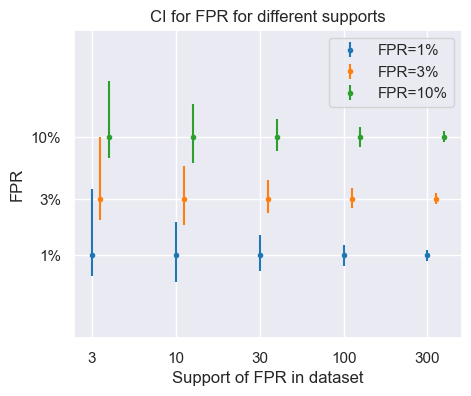

In [20]:
plt.figure(figsize=(5, 4))

for j, eer in enumerate(fpr_list):
    plt.errorbar(
        x=np.arange(len(support_list)) + 0.1 * j, 
        y=[fpr_list[j]] * len(support_list),
        yerr=[fpr_list[j] - ci[j,:,0], ci[j,:,1] - fpr_list[j]],
        fmt=".",
        label=f"FPR={fpr_list[j]:.0%}"
    )
    
plt.xticks(ticks=range(len(support_list)), labels=support_list)
plt.yscale("log")
plt.yticks(ticks=fpr_list, labels=fpr_list)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1., decimals=0))
plt.ylim([2e-3, 8e-1])
plt.grid("major")
plt.xlabel("Support of FPR in dataset")
plt.ylabel("FPR")
plt.legend(loc="upper right")
plt.title("CI for FPR for different supports")
plt.show()

## How to compute confidence bands?

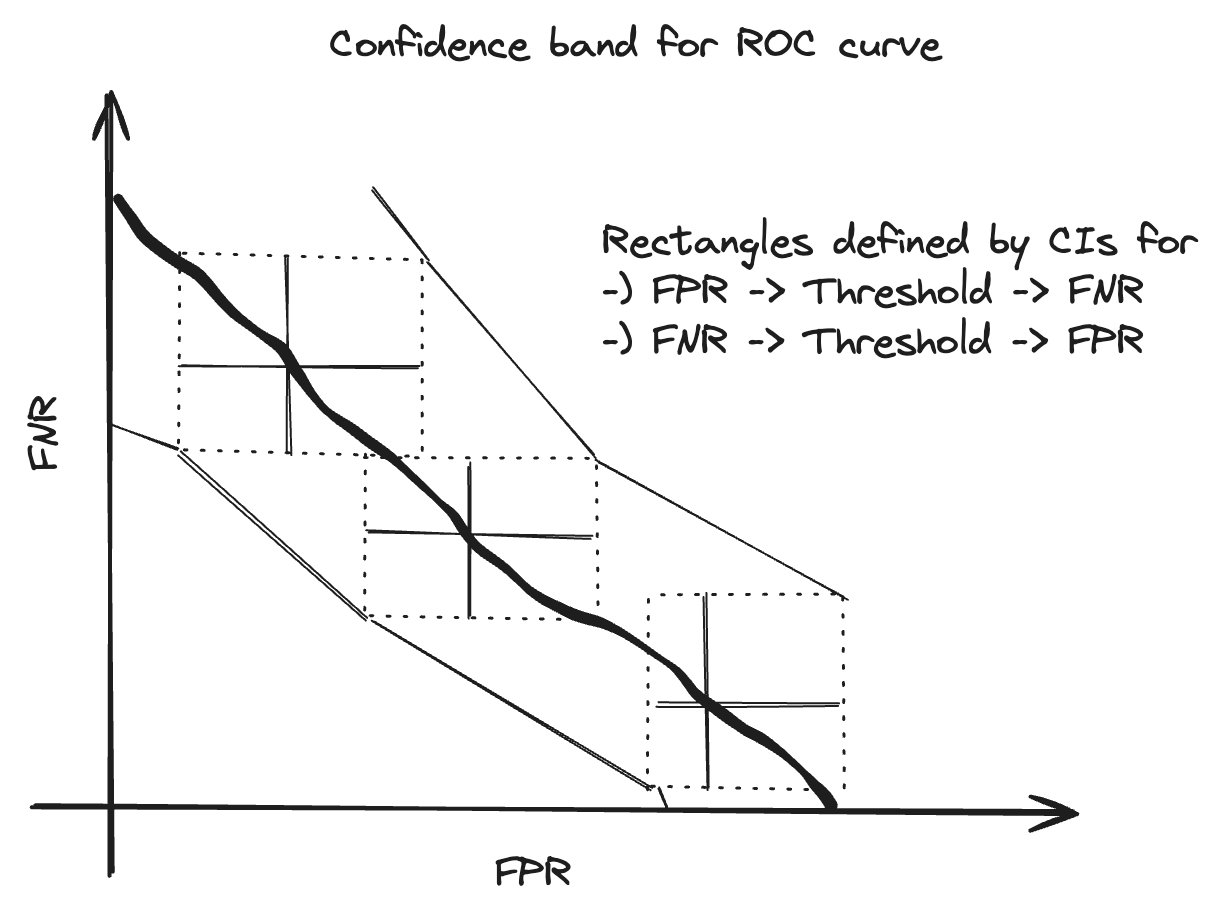

## Other approaches to compute confidence bands

In [21]:
dataset = NormalDataset(
    mu_pos=3.0,
    sigma_pos=3.75,
    sigma_neg=3.0,
    p_pos=0.5,
    n=500,
)
scores = dataset.sample()

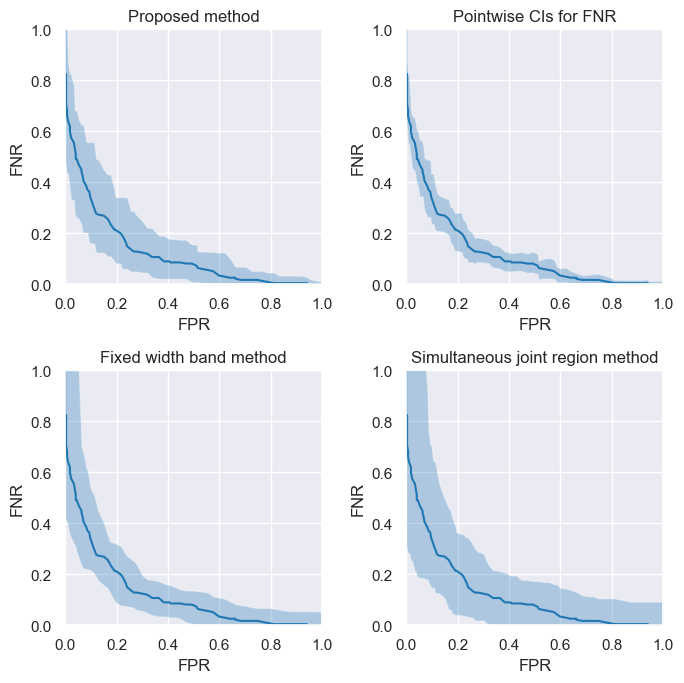

In [29]:
plt.figure(figsize=(7, 7))

plt.subplot(2, 2, 1)
fnr, fpr, fnr_ci, fpr_ci = roc_with_ci(scores, nb_points=100)
plt.plot(fpr, fnr)
plt.fill_between(fpr, fnr_ci[:, 0], fnr_ci[:, 1], alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("Proposed method")

plt.subplot(2, 2, 2)
fnr, fpr, fnr_ci, fpr_ci = pointwise_band_ci(scores, nb_points=100)
plt.plot(fpr, fnr)
plt.fill_between(fpr, fnr_ci[:, 0], fnr_ci[:, 1], alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("Pointwise CIs for FNR")

plt.subplot(2, 2, 3)
fnr, fpr, fnr_ci, fpr_ci = fixed_width_band_ci(scores, nb_points=100)
plt.plot(fpr, fnr)
plt.fill_between(fpr, fnr_ci[:, 0], fnr_ci[:, 1], alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("Fixed width band method")

plt.subplot(2, 2, 4)
fnr, fpr, fnr_ci, fpr_ci = simultaneous_joint_region_ci(scores, nb_points=100)
plt.plot(fpr, fnr)
plt.fill_between(fpr, fnr_ci[:, 0], fnr_ci[:, 1], alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("Simultaneous joint region method")

plt.tight_layout()
plt.show()

## "Constant width" ROC example

The ROC does not have constant width, it is narrower in the middle compared, but the width is approximately constant across two orders of magnitude (~1e-4 to 1e-2) on a logarithmic scale, which means that the absolute width of the confidence band varies across two orders of magnitude.

In [34]:
dataset = NormalDataset(
    mu_pos=0.8,
    mu_neg=np.sqrt(2),
    sigma_pos=0.1,
    sigma_neg=0.1,
    score_class="neg",
)
scores = dataset.sample(n=300_000, p_pos=0.5)

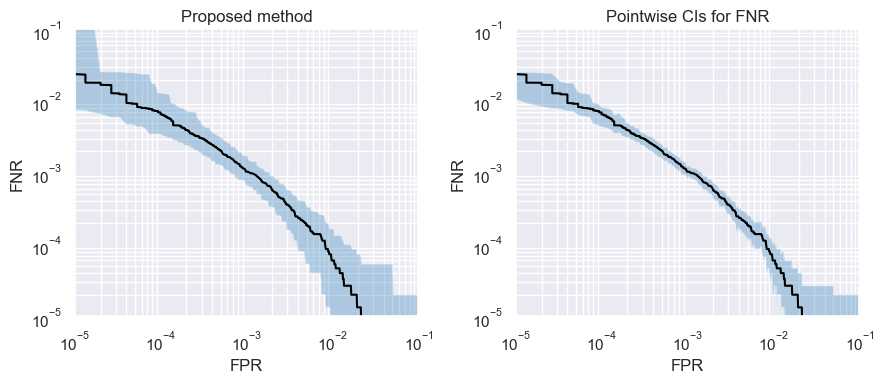

In [37]:
plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
fnr, fpr, fnr_ci, fpr_ci = roc_with_ci(
    scores=scores,
    fpr=np.logspace(-5, -1, 1_000),
    alpha=0.05,
)
plt.plot(fpr, fnr, "k-")
plt.fill_between(fpr, fnr_ci[:, 0], fnr_ci[:, 1], alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-5, 1e-1])
plt.ylim([1e-5, 1e-1])
plt.grid(which="both")
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("Proposed method")

plt.subplot(1, 2, 2)
fnr, fpr, fnr_ci, fpr_ci = pointwise_band_ci(
    scores=scores,
    fpr=np.logspace(-5, -1, 1_000),
    alpha=0.05,
)
plt.plot(fpr, fnr, "k-")
plt.fill_between(fpr, fnr_ci[:, 0], fnr_ci[:, 1], alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-5, 1e-1])
plt.ylim([1e-5, 1e-1])
plt.grid(which="both")
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("Pointwise CIs for FNR")

plt.tight_layout()
plt.show()

## Variation

In [61]:
dataset = NormalDataset(
    mu_pos=4.65,
    mu_neg=0.0,
    sigma_pos=1.0,
    sigma_neg=1.0,
)
fpr = 0.01
threshold = dataset.threshold_at_fpr(0.01)
fnr = dataset.fnr(threshold)

nb_samples = 5_000

print(f"Target FPR: {fpr:.3%}")
print(f"Threshold: {threshold:.3f}")
print(f"Dataset FPR: {dataset.fpr(threshold):.3%}")
print(f"Dataset FNR: {dataset.fnr(threshold):.3%}")
print()

scores = dataset.sample(n=10_000)
scores_threshold = scores.threshold_at_fpr(fpr)

print(f"Measured threshold: {scores_threshold:.3f}")
print(f"Measured FPR: {scores.fpr(scores_threshold):.3%}")
print(f"Measured FNR: {scores.fnr(scores_threshold):.3%}")
print(f"FPR support: {scores.cm(scores_threshold).fp()}")
print(f"FNR support: {scores.cm(scores_threshold).fn()}")

Target FPR: 1.000%
Threshold: 2.326
Dataset FPR: 1.000%
Dataset FNR: 1.007%

Measured threshold: 2.280
Measured FPR: 1.004%
Measured FNR: 0.762%
FPR support: 49
FNR support: 39


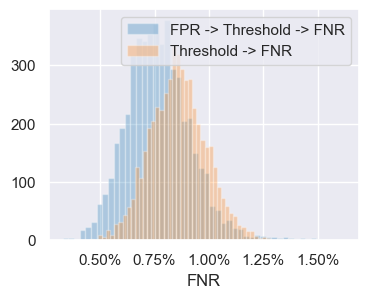

In [63]:
fnr_samples = scores.bootstrap_metric(
    lambda s: s.fnr(s.threshold_at_fpr(fpr)),
    config=BootstrapConfig(nb_samples=nb_samples)
)
fnr_threshold_samples = scores.bootstrap_metric(
    lambda s: s.fnr(threshold),
    config=BootstrapConfig(nb_samples=nb_samples),
)

plt.figure(figsize=(4, 3))
plt.hist(fnr_samples, bins=50, alpha=0.3, label="FPR -> Threshold -> FNR")
plt.hist(fnr_threshold_samples, bins=50, alpha=0.3, label="Threshold -> FNR")
plt.xlabel("FNR")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.))
plt.legend()
plt.show()

## How to bootstrap

In [78]:
scores = Scores(pos=[4, 5, 6, 7, 8], neg=[1, 2, 3])
nb_samples = 5

print("Original scores")
print(f"pos={scores.pos}, neg={scores.neg}")
print()

print("Bootstrap samples")
for _ in range(nb_samples):
    sample = scores.bootstrap_sample()
    print(f"pos={sample.pos}, neg={sample.neg}")
print()

print("Stratified sampling")
for _ in range(nb_samples):
    sample = scores.bootstrap_sample(config=BootstrapConfig(stratified_sampling=True))
    print(f"pos={sample.pos}, neg={sample.neg}")
print()

print("Smoothed sampling")
with np.printoptions(precision=1, floatmode="fixed"):
    for _ in range(nb_samples):
        sample = scores.bootstrap_sample(config=BootstrapConfig(smoothing=True))
        print(f"pos={sample.pos}, neg={sample.neg}")
print()

print("Stratified and smoothed sampling")
with np.printoptions(precision=1, floatmode="fixed"):
    for _ in range(nb_samples):
        sample = scores.bootstrap_sample(
            config=BootstrapConfig(smoothing=True, stratified_sampling=True)
        )
        print(f"pos={sample.pos}, neg={sample.neg}")
print()

Original scores
pos=[4 5 6 7 8], neg=[1 2 3]

Bootstrap samples
pos=[5 6 6 7 8], neg=[1 2 2]
pos=[5 5 5 5 7 7 8], neg=[1]
pos=[4 5 5 7 7 7 7], neg=[1]
pos=[4 4 5 7], neg=[1 1 2 3]
pos=[5 5 5 6 6], neg=[1 3 3]

Stratified sampling
pos=[4 5 5 7 8], neg=[1 2 3]
pos=[5 6 7 7 8], neg=[1 2 2]
pos=[4 5 5 7 7], neg=[1 1 3]
pos=[4 4 5 5 7], neg=[1 1 3]
pos=[4 5 6 7 8], neg=[3 3 3]

Smoothed sampling
pos=[4.4 4.7 5.3 6.2 6.4 6.6 6.7], neg=[2.0]
pos=[4.8 5.3 5.6 6.0], neg=[0.8 0.9 1.1 2.0]
pos=[5.4 6.0 6.3 7.5 7.8 8.2], neg=[1.5 2.0]
pos=[4.4 5.0 5.7 6.8], neg=[1.7 2.5 3.0 3.6]
pos=[4.4 4.7 5.0 6.1], neg=[-0.2  0.6  2.9  3.0]

Stratified and smoothed sampling
pos=[3.5 3.5 6.6 7.3 7.9], neg=[1.0 1.4 3.8]
pos=[4.4 5.0 5.0 7.0 8.1], neg=[3.0 3.0 3.0]
pos=[4.6 4.9 5.5 5.5 6.8], neg=[1.4 1.7 2.4]
pos=[3.4 6.0 7.6 7.8 8.6], neg=[0.7 1.3 2.8]
pos=[5.0 6.0 6.0 6.0 8.0], neg=[0.7 1.8 4.2]



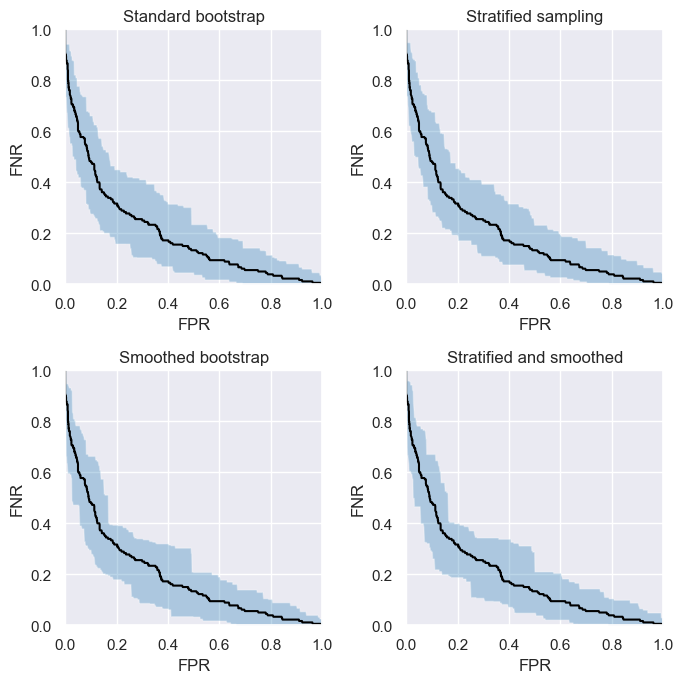

In [64]:
dataset = NormalDataset(
    mu_pos=2.0,
    sigma_pos=3.75,
    sigma_neg=3.0,
    p_pos=0.2,
)
scores = dataset.sample(n=1_000)

plt.figure(figsize=(7, 7))

plt.subplot(2, 2, 1)
fnr, fpr, fnr_ci, fpr_ci = roc_with_ci(
    scores,
    nb_points=1_000,
    alpha=0.05,
    config=BootstrapConfig(
        stratified_sampling=False,
        smoothing=False,
    ),
)
plt.plot(fpr, fnr, "k-")
plt.fill_between(fpr, fnr_ci[:, 0], fnr_ci[:, 1], alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("Standard bootstrap")

plt.subplot(2, 2, 2)
fnr, fpr, fnr_ci, fpr_ci = roc_with_ci(
    scores,
    nb_points=1_000,
    alpha=0.05,
    config=BootstrapConfig(
        stratified_sampling=True,
        smoothing=False,
    ),
)
plt.plot(fpr, fnr, "k-")
plt.fill_between(fpr, fnr_ci[:, 0], fnr_ci[:, 1], alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("Stratified sampling")

plt.subplot(2, 2, 3)
fnr, fpr, fnr_ci, fpr_ci = roc_with_ci(
    scores,
    nb_points=1_000,
    alpha=0.05,
    config=BootstrapConfig(
        stratified_sampling=False,
        smoothing=True,
    ),
)
plt.plot(fpr, fnr, "k-")
plt.fill_between(fpr, fnr_ci[:, 0], fnr_ci[:, 1], alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("Smoothed bootstrap")

plt.subplot(2, 2, 4)
fnr, fpr, fnr_ci, fpr_ci = roc_with_ci(
    scores,
    nb_points=1_000,
    alpha=0.05,
    config=BootstrapConfig(
        stratified_sampling=True,
        smoothing=True,
    ),
)
plt.plot(fpr, fnr, "k-")
plt.fill_between(fpr, fnr_ci[:, 0], fnr_ci[:, 1], alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("Stratified and smoothed")

plt.tight_layout()
plt.show()